Felipe Bartelt de Assis Pessoa - 2016026841


# Redes RBF

Primeiramente, definiu-se a função `h_rbf` que calcula a resposta da função radial do neurônio em questão. Essa função recebe como parâmetros: um vetor `x` que representa todos os dados de um exemplo de treino, os centros do k-médias `centers` e a matriz de covariância `cov_mat`. A função tem um tratamento para o caso de `cov_mat` ser um escalar, correspondente à variância de um vetor e não uma matriz de covariâncias, nesse caso, toma-se `cov_mat`$= \sigma^2I$, onde $\sigma^2$ representa a variância e $I$ a matriz identidade. A função retorna a resposta da função radial normalizada.

Definiu-se também a função `train_RBF` para o treino da rede neural RBF, cujos parâmetros são: os dados de treino, de entrada e saída, `x_train, y_train`, respectivamente; e o número de *clusters* desejados `hidden_dim`. Essa função utiliza o cálculo do k-médias fornecido pelo `sklearn.cluster` para gerar os *clusters* e utiliza a função `h_rbf` para a modelagem. Ao final a função retorna uma tupla de 4 elementos, sendo esses, em ordem: a matriz `H` que contém todas as respostas das funções radiais, o vetor de pesos `w` da camada de saída, os centros do k-médias `centers` e uma lista com todas as matrizes de covariância `cov_list`.

Por último, definiu-se a função `eval_RBF`, cuja função é avaliar a resposta do modelo gerado. Seus parâmetros são os dados de teste `x_test` e a tupla gerada por `train_RBF`, `rbf_params`. De forma análoga, a função calcula a resposta do modelo para os dados de teste e retorna a saída do modelo `y_hat`.

In [1]:
from sklearn.cluster import KMeans

def h_rbf(x, centers, cov_mat):
    m = x.shape[0]
    dist = x - centers
    
    if cov_mat.ndim < 2:
        cov_mat = np.eye(m) * cov_mat

    norm_factor = 1/np.sqrt((2*np.pi)**m * np.linalg.det(cov_mat))
    h = norm_factor * np.exp(-0.5 * dist @ np.linalg.pinv(cov_mat) @ dist.T)

    return h

def train_RBF(x_train, y_train, hidden_dim):
    km = KMeans(hidden_dim).fit(x_train)
    centers = km.cluster_centers_
    cov_list = []
    N = x_train.shape[0]
    h = np.zeros((N, hidden_dim))

    for p in range(hidden_dim):
        p_samples = (km.labels_ == p).nonzero()
        cov_mat = np.cov(x_train[p_samples], rowvar=False, ddof=0)
        cov_list.append(np.copy(cov_mat))
        center = centers[p,:]
        h[:,p] = np.array([h_rbf(x_sample, centers[p], cov_mat) for x_sample in x_train])
    
    h_aug = np.append(np.ones((N, 1)), h, axis=1)
    w = np.linalg.pinv(h_aug) @ y_train

    return (h, w, centers, cov_list)

def eval_RBF(x_test, rbf_params):
    w = rbf_params[1]
    hidden_dim = rbf_params[0].shape[1]
    centers = rbf_params[2]
    cov_list = rbf_params[3]
    N = x_test.shape[0]
    h = np.zeros((N, hidden_dim))
    
    for p in range(hidden_dim):
        cov_mat = np.copy(cov_list[p])
        center = centers[p,:]
        h[:,p] = np.array([h_rbf(x_sample, centers[p], cov_mat) for x_sample in x_test])
    
    h = np.append(np.ones((N, 1)), h, axis=1)
    y_hat = h @ w
    
    return y_hat



Uma vez que seria necessário iterar diversas redes RBF, com diferentes números de *clusters*, modificou-se a função `make_grid`, já definida no exercício sobre ELMs

In [307]:
def make_grid(X, Y, dim_list, title):
    margin = 0.25
    mesh_size = 0.02
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    x_range = np.linspace(x_min, x_max, 100)
    y_range = np.linspace(y_min, y_max, 100)
    xx, yy = np.meshgrid(x_range, y_range)
    zz = np.c_[xx.ravel(), yy.ravel()]

    fig = make_subplots(rows= len(dim_list)//2, cols=2, subplot_titles= tuple('k='+str(i) for i in dim_list))
    fig.update_layout(autosize = False, width = 800, height = 800, margin=dict(l = 80, r = 80, t = 80, b = 80), title = dict(text =                             title, x = 0.5, y = 0.95), xaxis_title ='test')
    fig.update_xaxes(range=[x_min, x_max])
    fig.update_yaxes(range=[y_min, y_max])

    for i in range(1, len(dim_list)+1):
        fig['layout']['xaxis{}'.format(i)]['title']='x1'
        fig['layout']['yaxis{}'.format(i)]['title']='x2'
        fig['layout']['yaxis{}'.format(i)]['title_standoff'] = 2
    surf_list = []

    for i, p in enumerate(dim_list):
        rbf = train_RBF(X, Y, p)
        y_hat = eval_RBF(zz, rbf).reshape(xx.shape)
        region = go.Contour(x= x_range, y= y_range, z= y_hat, coloraxis = "coloraxis", opacity = 0.8)
        fig.add_trace(region, row = int(np.ceil((i+1)/2)), col = 2**(i%2))
        fig.add_trace(black_sample, row = int(np.ceil((i+1)/2)), col = 2**(i%2))
        fig.add_trace(red_sample, row = int(np.ceil((i+1)/2)), col = 2**(i%2))
        centers = rbf[2]
        center_plot = go.Scatter(x = centers[:,0], y= centers[:, 1], mode='markers', showlegend = False, 
                                 marker = dict(symbol = 'x', size = 9, color = '#FFBC0D', opacity = 0.7))
        fig.add_trace(center_plot, row = int(np.ceil((i+1)/2)), col = 2**(i%2))
        surf_list.append((x_range, y_range, y_hat))

    fig.update_layout(coloraxis = {'colorscale' : 'RdGy_r'})

    return fig, surf_list

## 2D-Normals

O primeiro banco de dados utilizado foi o 2D-Normals, apresentado a seguir:

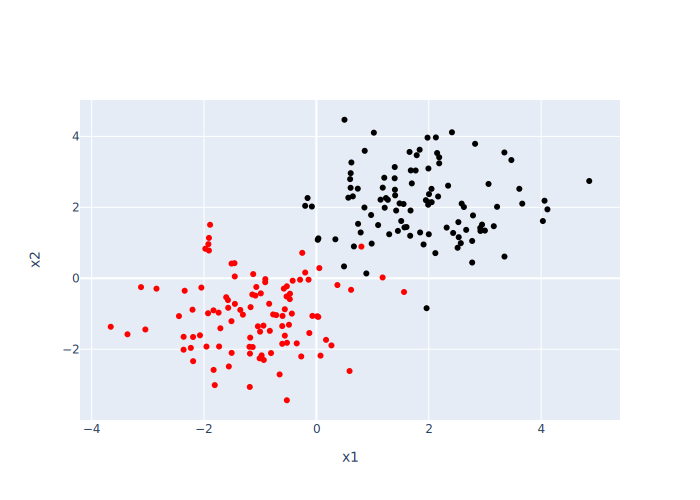

In [252]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import datasets

X, Y = datasets.make_blobs(200, centers = [[2,2],[-1,-1]])

red_sample = go.Scatter(x=X[Y==1,0], y=X[Y==1,1], mode = 'markers', marker_color = 'red', showlegend = False)
black_sample = go.Scatter(x=X[Y==0,0], y=X[Y==0,1], mode = 'markers', marker_color = 'black', showlegend = False)
fig = go.Figure(red_sample)
fig.update_layout(xaxis={'title':'x1'}, yaxis={'title':'x2'})
fig.add_trace(black_sample)
fig.show(renderer = 'svg')


Modificou-se as classes nulas, bolinhas pretas, para classes $-1$, uma vez que foi percebido que essa alteração evitava erros quanto à matrizes singulares, durante o funcionamento do algoritmo.

Assim, plota-se a resposta obtida para os números de clusters: $[1, 2, 3, 5, 8, 10]$. Os centros obtidos pelo k-médias são mostrados como X's amarelos

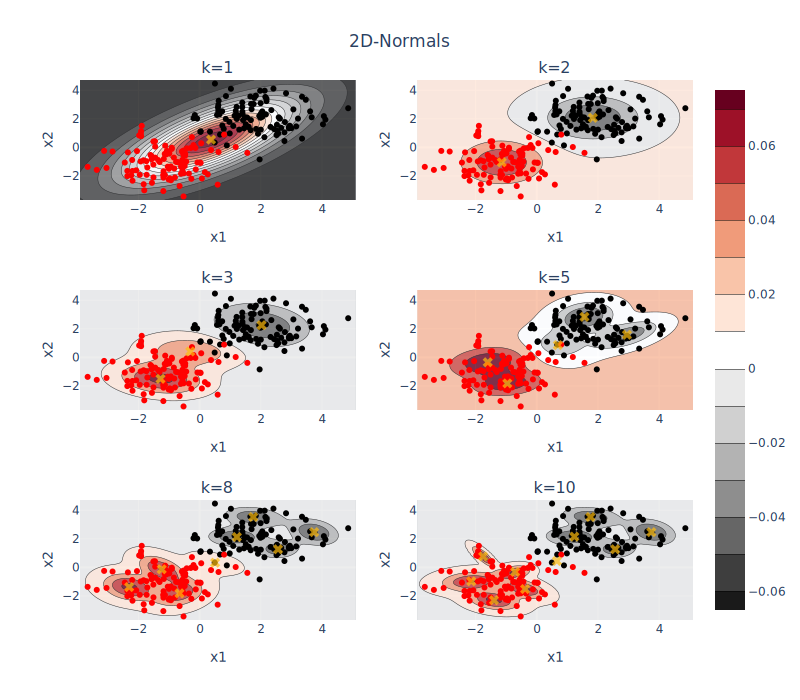

In [253]:
Y[Y==0] = -1
dim_list = [1, 2, 3, 5, 8, 10]
fig2, surf_list = make_grid(X, Y, dim_list, '2D-Normals')
fig2.show(renderer = 'svg', width = 800, height = 700)


Observando o comportamento anterior, tomou-se como aproximações boas as redes com 2 e 3 *clusters*. As redes com 5, 8 e 10 aparentam superdimensionadas e a com 1 aparenta subdimensionada. 

A fim de se visualizar a superfície formada pela rede RBF, tomou-se como base a rede com $k=2$, que apresenta a seguinte superfície de resposta:

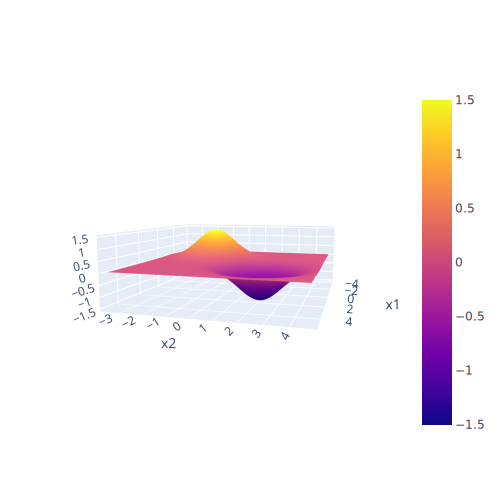

In [254]:
fig = go.Figure(go.Surface(x = surf_list[1][0], y = surf_list[1][1], z = surf_list[1][2]))
fig.update_layout(autosize=False, scene_camera_eye=dict(x=3, y=0.88, z=0.44), width=500, height=500, margin=dict(l=65, r=50, b=65, t=90))
fig.update_scenes(xaxis_title ={'text':'x1'}, yaxis_title = {'text':'x2'}, zaxis_title = {'text':'y'})
fig.show(renderer = 'svg')

## XOR

O segundo banco de dados utilizado foi o XOR:

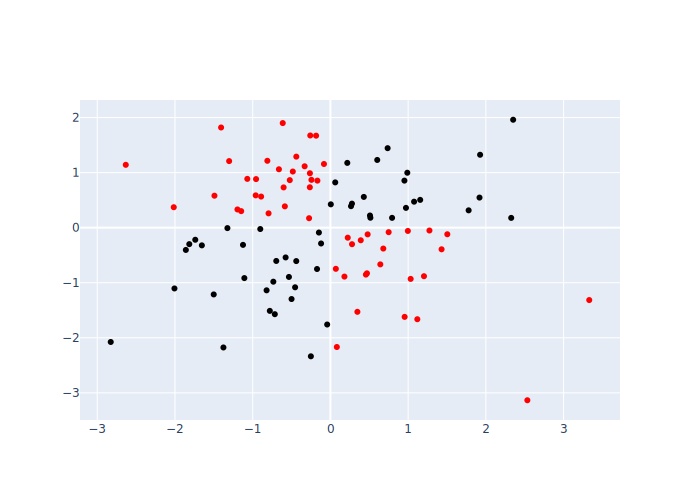

In [446]:
X = np.random.default_rng().standard_normal((100, 2))
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)

red_sample = go.Scatter(x=X[Y==1, 0], y=X[Y==1,1], mode = 'markers', marker_color = 'red', showlegend = False)
black_sample = go.Scatter(x=X[Y==0,0], y=X[Y==0,1], mode = 'markers', marker_color = 'black', showlegend = False)
fig = go.Figure(red_sample)
fig.add_trace(black_sample)
fig.show(renderer = 'svg')


Novamente, modificou-se as classes nulas para classes $-1$, correspondentes às bolinhas pretas e plotou-se as respostas para os números de clusters: $[1, 2, 3, 5, 8, 10]$. Novamente, os centros são identificados por X's amarelos:

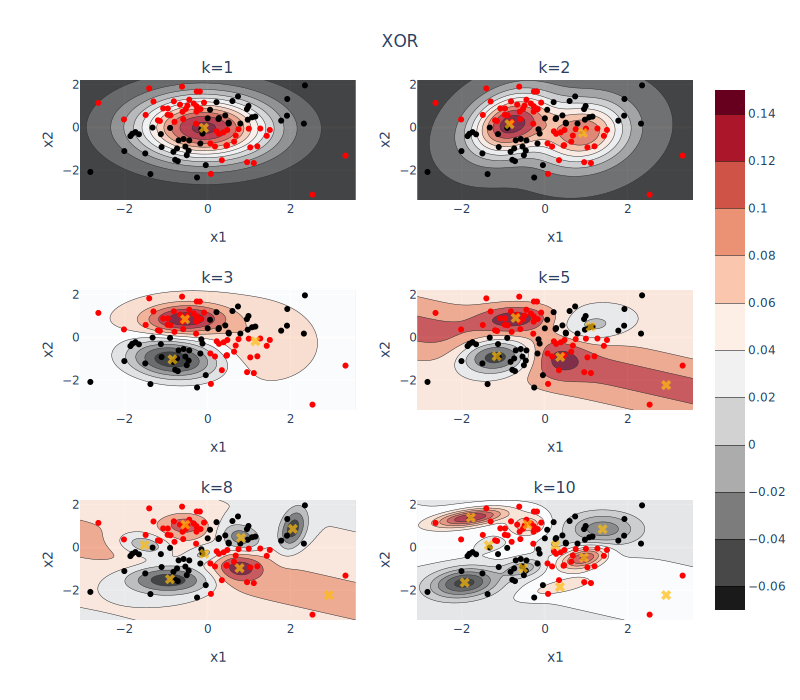

In [447]:
Y[Y==0] = -1
dim_list = [1, 2, 3, 5, 8, 10]
fig2, surf_list = make_grid(X, Y, dim_list, 'XOR')
fig2.show(renderer = 'svg', width = 800, height = 700)


Observando o comportamento anterior, tomou-se como aproximações boa a redes com 5 *clusters*. As redes com 1, 2 e 3 aparentam subdimensionada, enquanto as com 8 e 10 aparentam superdimensionadas . 

A fim de se visualizar a superfície formada pela rede RBF, tomou-se como base a rede com $k=5$, que apresenta a seguinte superfície de resposta:

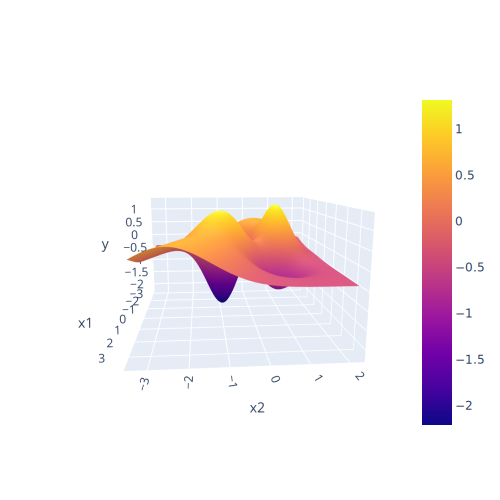

In [452]:
fig = go.Figure(go.Surface(x = surf_list[3][0], y = surf_list[3][1], z = surf_list[3][2]))
fig.update_layout(autosize=False, scene_camera_eye=dict(x=2.4, y=-0.2, z=0.5), width=500, height=500, margin=dict(l=65, r=50, b=65, t=90))
fig.update_scenes(xaxis_title ={'text':'x1'}, yaxis_title = {'text':'x2'}, zaxis_title = {'text':'y'})
fig.show(renderer = 'svg')

## Circles

Em seguida, tomou-se a base de dados Circles:

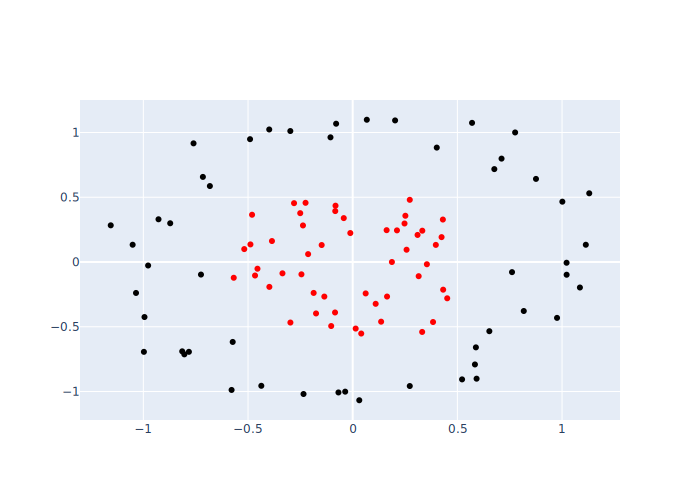

In [453]:
X, Y = datasets.make_circles(noise = 0.12, factor = 0.4)
Y[Y==0] = -1
red_sample = go.Scatter(x=X[Y==1,0], y=X[Y==1,1], mode = 'markers', marker_color = 'red', showlegend = False)
black_sample = go.Scatter(x=X[Y==-1,0], y=X[Y==-1,1], mode = 'markers', marker_color = 'black', showlegend = False)
fig2 = go.Figure(red_sample)
fig2.add_trace(black_sample)
fig2.show(renderer = 'svg')


Novamente, obteve-se as repostas para $[1,2,3,5,8,10]$ *clusters*:

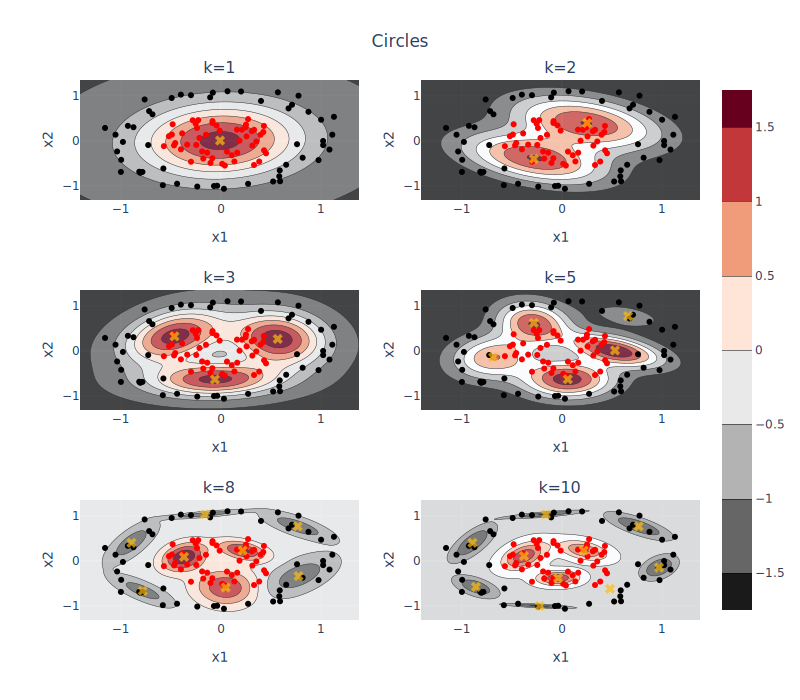

In [454]:
dim_list = [1, 2, 3, 5, 8, 10]
fig2, surf_list = make_grid(X, Y, dim_list, 'Circles')
fig2.show(renderer = 'svg', width = 800, height = 700)


Observando o comportamento anterior, tomou-se como aproximações boa a redes com 1 e 2 *clusters*. As redes com 3, 5,8 e 10 aparentam estar superdimensionadas.

A fim de se visualizar a superfície formada pela rede RBF, tomou-se como base a rede com $k=1$, que apresenta a seguinte superfície de resposta:

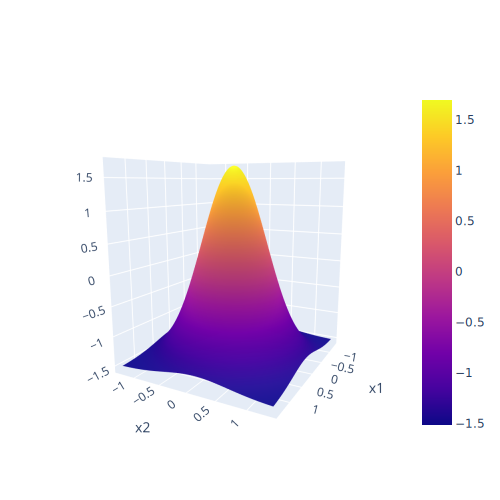

In [455]:
fig = go.Figure(go.Surface(x = surf_list[0][0], y = surf_list[0][1], z = surf_list[0][2]))
fig.update_layout(autosize=False, scene_camera_eye=dict(x=2, y=1.08, z=0.44), width=500, height=500, margin=dict(l=65, r=50, b=65, t=90))
fig.update_scenes(xaxis_title ={'text':'x1'}, yaxis_title = {'text':'x2'}, zaxis_title = {'text':'y'})
fig.show(renderer = 'svg')

## Spirals

Por último, utilizou-se os dados Spirals:

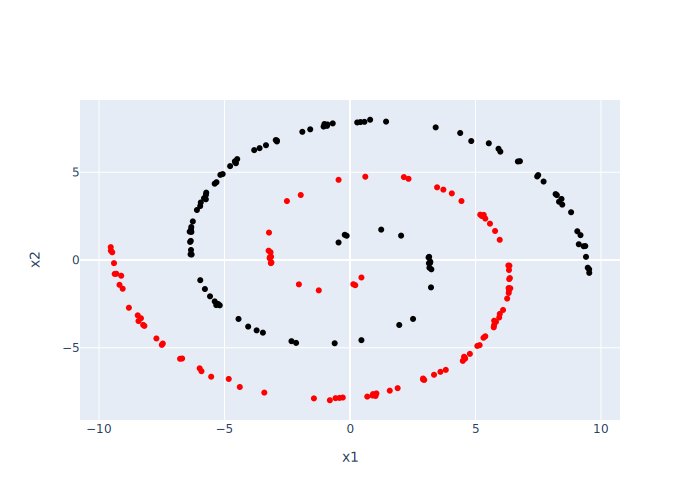

In [270]:
def twospirals(n_points, noise=0.5, factor = 1):
    # Returns the two spirals dataset.
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * factor * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.default_rng().standard_normal((n_points,1)) * noise
    d1y = np.sin(n)*n + np.random.default_rng().standard_normal((n_points,1)) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))


X, Y = twospirals(100, 0.05, 0.7)

red_sample = go.Scatter(x=X[Y==1,0], y=X[Y==1,1], mode = 'markers', marker_color = 'red', showlegend=False)
black_sample = go.Scatter(x=X[Y==0,0], y=X[Y==0,1], mode = 'markers', marker_color = 'black', showlegend=False)
fig = go.Figure(red_sample)
fig.update_layout(xaxis={'title':'x1'}, yaxis={'title':'x2'})
fig.add_trace(black_sample)
fig.show(renderer = 'svg')


Tomou-se um procedimento análogo, porém, para essa base de dados a resposta da rede com apenas $1$ *cluster* obteve valores muito pequenos, o que tornou a escala de cores péssima. Dessa forma, não se plotou a resposta para esse valor, que foi substituído por um número maior de *clusters*. Sendo assim, as respostas para $k = [2,3,5,8,10,15]$ são:

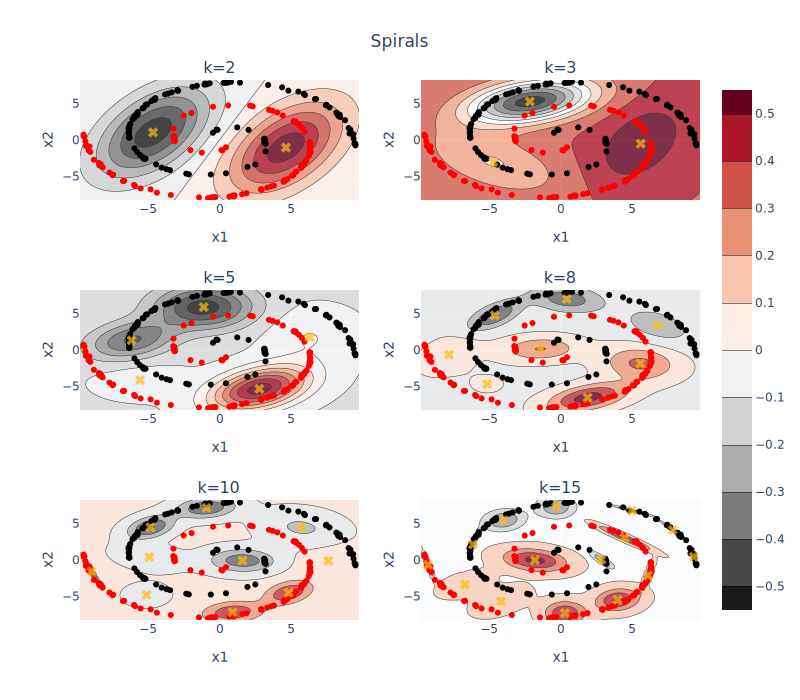

In [308]:
Y[Y==0] = -1

dim_list = [2, 3, 5, 8, 10, 15]
fig2, surf_list = make_grid(X, Y, dim_list, 'Spirals')
fig2.show(renderer = 'svg', width = 800, height = 700)


Para essa base, é fácil notar que o desempenho é muito ruim para $k<10$, porém, mesmo para $k=10,15$ a resposta obtida não é excelente, havendo diversas amostras classificadas incorretamente. Dessa forma, tomou-se como superfície de interesse a gerada por $k=15$, uma vez que é a resposta que mais aparenta "tentar" seguir um caminho espiral:

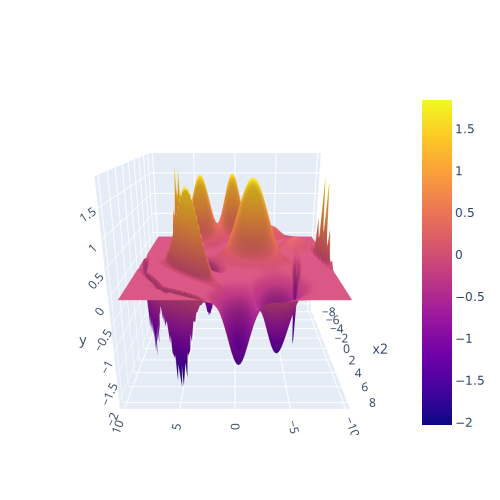

In [321]:
fig = go.Figure(go.Surface(x = surf_list[5][0], y = surf_list[5][1], z = surf_list[5][2]))
fig.update_layout(autosize=False, scene_camera_eye=dict(x=0, y=2, z=0.7), width=500, height=500, margin=dict(l=65, r=50, b=65, t=90))
fig.update_scenes(xaxis_title ={'text':'x1'}, yaxis_title = {'text':'x2'}, zaxis_title = {'text':'y'})
fig.show(renderer = 'svg')

## Aproximação da função $sinc$

Buscou-se aproximar uma função $sinc(x)$, por meio de um conjunto de dados randômicos e acrescidos de ruído gaussiano. Gerou-se as $100$ amostras de treino apresentadas a seguir:

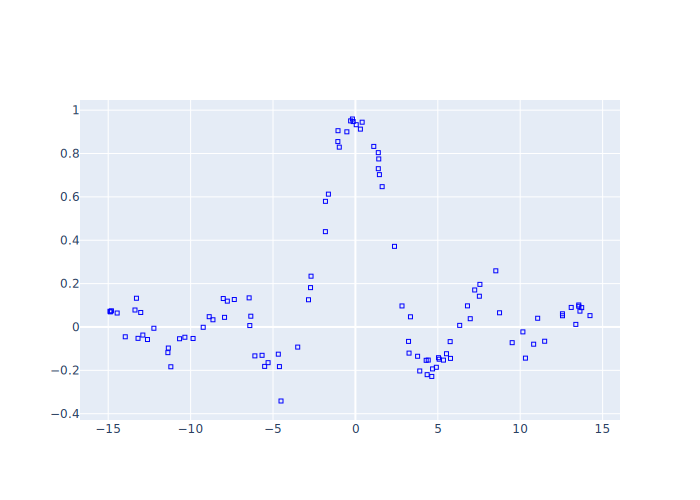

In [29]:
import numpy as np
import plotly.graph_objects as go
x = np.random.default_rng().uniform(-15, 15, 100)
noise = np.random.default_rng().normal(0, 0.05,100)
y = np.sin(x)/x + noise
sort_idx = np.argsort(x)

train_data = go.Scatter(x = x, y =y, mode = 'markers', marker_color = 'blue', marker_size = 4, marker_symbol = 'square-open', name='amostras')
fig = go.Figure(train_data)
fig.show(renderer = 'svg', engine ='kaleido')


Por meio dos dados gerados, gerou-se, primeiramente, um modelo RBF para *5* neurônios intermediários com base nos dados gerados. A aproximação obtida pelo modelo foi testada para um novo conjunto, gerado da mesma forma, porém com $50$ amostras.

A resposta obtida pelo modelo, $\widehat{y}$, as amostras de treino e a resposta esperada $sinc(x)$ são mostradas a seguir:

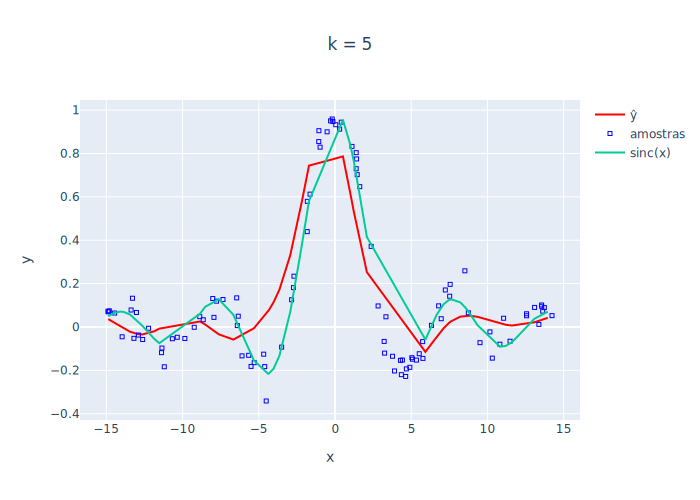

In [30]:
x = x.reshape((-1,1))
y = y.reshape((-1,1))

rbf = train_RBF(x,y,5)
x_test = np.random.default_rng().uniform(-15, 15, 50).reshape((-1,1))
y_test = np.sin(x_test)/x_test
y_hat = eval_RBF(x_test, rbf)
sort_idx = np.argsort(x_test, axis=0)

x_p = x_test.flatten()[sort_idx.flatten()]
y_t = y_test.flatten()[sort_idx.flatten()]
y_p = y_hat.flatten()[sort_idx.flatten()]

fig = go.Figure(go.Scatter(x=x_p, y=y_p, mode= 'lines', marker_color = 'red', name = 'ŷ'))
fig.update_layout(xaxis_title = 'x', yaxis_title = 'y', title= {'text':'k = 5', 'x':0.5})
fig.add_trace(train_data)
fig.add_trace(go.Scatter(x = x_p, y=y_t, mode='lines', name='sinc(x)'))
fig.show(renderer = 'svg', engine='kaleido')


O erro quadrático médio (MSE) obtido por essa aproximação foi igual a

In [31]:
print('MSE = ', float((y_hat - y_test).T @ (y_hat - y_test)/y_hat.shape[0]))

MSE =  0.019466884157823383



Em seguida, treinou-se, para os mesmos dados gerados, uma rede RBF com $10$ neurônios na camada intermediária. Essa rede foi testada da mesma forma, com outros $50$ dados de teste.

A resposta obtida pelo modelo, $\widehat{y}$, as amostras de treino e a resposta esperada $sinc(x)$ são mostradas a seguir:

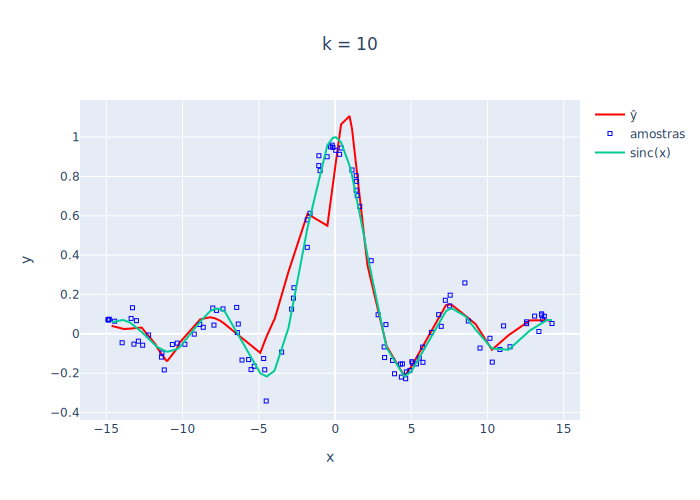

In [32]:
rbf = train_RBF(x,y,10)
x_test = np.random.default_rng().uniform(-15, 15, 50).reshape((-1,1))
y_test = np.sin(x_test)/x_test
y_hat = eval_RBF(x_test, rbf)
sort_idx = np.argsort(x_test, axis=0)

x_p = x_test.flatten()[sort_idx.flatten()]
y_t = y_test.flatten()[sort_idx.flatten()]
y_p = y_hat.flatten()[sort_idx.flatten()]

fig = go.Figure(go.Scatter(x=x_p, y=y_p, mode= 'lines', marker_color = 'red', name = 'ŷ'))
fig.update_layout(xaxis_title = 'x', yaxis_title = 'y', title= {'text':'k = 10', 'x':0.5})
fig.add_trace(train_data)
fig.add_trace(go.Scatter(x = x_p, y=y_t, mode='lines', name='sinc(x)'))
fig.show(renderer='svg', engine='kaleido')


Para 10 neurônios, obteve-se o seguinte MSE:

In [34]:
print('MSE = ', float((y_hat - y_test).T @ (y_hat - y_test)/y_hat.shape[0]))

MSE =  0.013880629152109835



Por último, testou-se o comportamento da rede RBF para 20 neurônios. A rede foi testada de maneira análoga à anterior e o gráfico obtido foi:

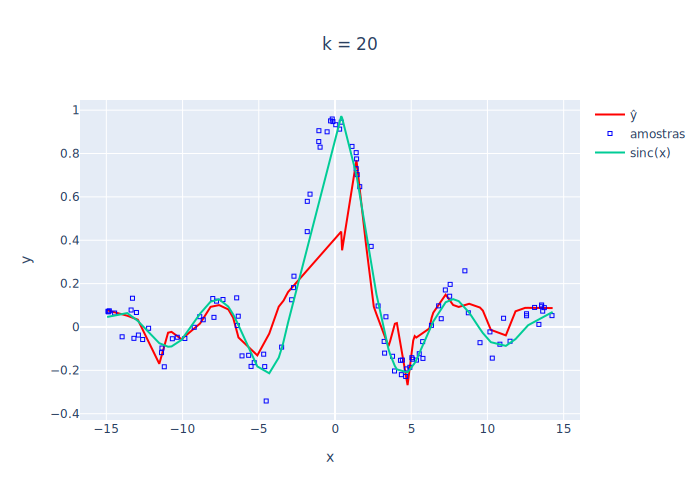

In [38]:
rbf = train_RBF(x,y,20)
x_test = np.random.default_rng().uniform(-15, 15, 50).reshape((-1,1))
y_test = np.sin(x_test)/x_test
y_hat = eval_RBF(x_test, rbf)
sort_idx = np.argsort(x_test, axis=0)

x_p = x_test.flatten()[sort_idx.flatten()]
y_t = y_test.flatten()[sort_idx.flatten()]
y_p = y_hat.flatten()[sort_idx.flatten()]

fig = go.Figure(go.Scatter(x=x_p, y=y_p, mode= 'lines', marker_color = 'red', name = 'ŷ'))
fig.update_layout(xaxis_title = 'x', yaxis_title = 'y', title= {'text':'k = 20', 'x':0.5})
fig.add_trace(train_data)
fig.add_trace(go.Scatter(x = x_p, y=y_t, mode='lines', name='sinc(x)'))
fig.show(renderer='svg', engine='kaleido')


Para esse número de *clusters*, obteve-se:

In [39]:
print('MSE = ', float((y_hat - y_test).T @ (y_hat - y_test)/y_hat.shape[0]))

MSE =  0.02198484682982922



Dessa forma, obteve-se como melhor aproximação, dentre as testadas, a rede RBF com 10 *clusters*, tendo como base o erro quadrático médio. Porém, não é possível afirmar que esse número de *clusters* forneça a melhor aproximação, uma vez que seria necessário um estudo de validação cruzada para que se pudesse afirmar com propriedade o melhor número de neurônios.

Com isso em mente, iterou-se 15 vezes o treinamento das redes RBF para todos os números de *clusters* entre 1 e 18, o erro quadrático médio nessas iterações em função do número de *clusters* é mostrado a seguir:

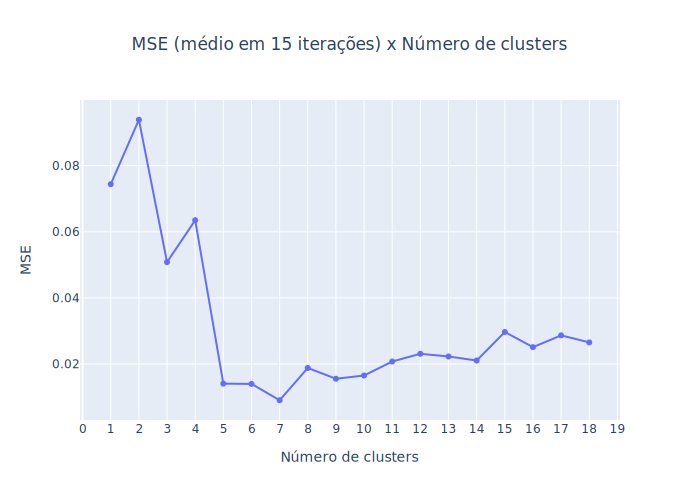

In [40]:
mse_list = []
for i in range(1,19):
    mse = 0
    for _ in range(15):
        rbf = train_RBF(x,y,i)
        x_test = np.random.default_rng().uniform(-15, 15, 50).reshape((-1,1))
        y_test = np.sin(x_test)/x_test
        y_hat = eval_RBF(x_test, rbf)
        mse = mse + float((y_hat - y_test).T @ (y_hat - y_test)/y_hat.shape[0])
    mse_list.append(mse/15)

fig = go.Figure(go.Scatter(x=np.arange(1,21,1), y=mse_list))
fig.update_layout(title = {'text':'MSE (médio em 15 iterações) x Número de clusters', 'x': 0.5}, xaxis = {'title':'Número de clusters', 'dtick':1}, yaxis = {'title':'MSE'})
fig.show(renderer = 'svg', engine = 'kaleido')



Por meio dessa análise, permite-se dizer que o número ideal de centros do k-médias está entre 5 e 10. Sendo necessário mais iterações para obtenção de uma melhor estimativa.